# Out of Africa model

In [3]:
import moments
import demes
import demesdraw
import matplotlib.pyplot as plt
import pickle
import gzip
from IPython.display import Markdown as md
import warnings

# Function for printing syntax-highlighted YAML demes models
# If there is a better way to do this, tell me!!
def print_model(file_path):
    with open(file_path) as f:
        lines = f.read()
    return md("```yaml\n" + lines + "```")
warnings.filterwarnings('ignore')

## Parametrized model

We are working with the out of Africa model.

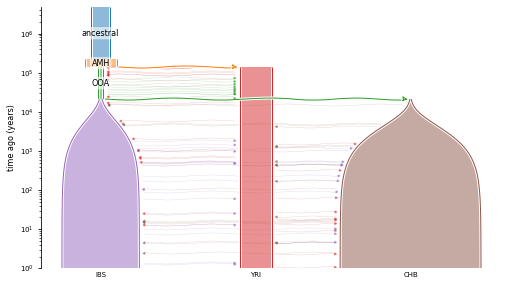

In [5]:
# this file contains the parametrization of the model
ooa_yml = "./gutenkunst_2009.yaml"
ooa = demes.load("./gutenkunst_2009.yaml")
demesdraw.tubes(ooa, log_time=True)
plt.show();

In [6]:
print_model(ooa_yml)

```yaml
# I modified to have IBS instead of CEU
description: The Gutenkunst et al. (2009) three-population model of
  human history, modified by replacing CEU with IBS.
doi:
  - https://doi.org/10.1371/journal.pgen.1000695
time_units: years
generation_time: 29
demes:
  - name: ancestral
    description: Equilibrium/root population
    epochs:
    - end_time: 220e3
      start_size: 7300
  - name: AMH
    description: Anatomically modern humans
    ancestors: [ancestral]
    epochs:
    - end_time: 140e3
      start_size: 12300
  - name: OOA
    description: Bottleneck out-of-Africa population
    ancestors: [AMH]
    epochs:
    - end_time: 21.2e3
      start_size: 2100
  - name: YRI
    description: Yoruba in Ibadan, Nigeria
    ancestors: [AMH]
    epochs:
    - start_size: 12300
      end_time: 0
  - name: IBS
    description: Iberian populations in Spain (IBS).
    ancestors: [OOA]
    epochs:
    - start_size: 1000
      end_size: 29725
      end_time: 0
  - name: CHB
    description: Han Chinese in Beijing, China
    ancestors: [OOA]
    epochs:
    - start_size: 510
      end_size: 54090
      end_time: 0
migrations:
  - demes: [YRI, OOA]
    rate: 25e-5
  - demes: [YRI, IBS]
    rate: 3e-5
  - demes: [YRI, CHB]
    rate: 1.9e-5
  - demes: [IBS, CHB]
    rate: 9.6e-5
```

# SFS inference

## Which paramaters do we want to infer?

I am following the [moments example](https://moments.readthedocs.io/en/latest/extensions/demes.html). I will infer the follwing parameters: TA, TB, and TF.



In [8]:
options = "./ooa_options.yaml"
print_model(options)


```yaml
parameters:
- name: N_B
  description: Bottleneck size for Eurasian populations
  values:
  - demes:
      OOA:
        epochs:
          0: start_size
- name: m_Af_Eu
  description: Symmetric migration rate between Afr and Eur populations
  upper_bound: 1e-3
  values:
  - migrations:
      1: rate
- name: TA
  description: Time before present of ancestral expansion
  values:
  - demes:
      ancestral:
        epochs:
          0: end_time
- name: TB
  description: Time of YRI-OOA split
  values:
  - demes:
      AMH:
        epochs:
          0: end_time
- name: TF
  description: Time of IBS-CHB split
  values:
  - demes:
      OOA:
       epochs:
         0: end_time
- name: Ne
  description: ancestral effective population size
  values:
  - demes:
      ancestral:
        epochs:
          0: start_size
- name: NA
  description: expansion size in AMH and YRI
  values:
  - demes:
      AMH:
        epochs:
          0: start_size
      YRI:
        epochs:
          0: start_size
- name: NB
  description: AMH bottleneck size
  values:
  - demes:
      OOA:
        epochs:
          0: start_size
- name: NEu0
  description: initial IBS size
  values:
  - demes:
      IBS:
        epochs:
          0: start_size
- name: NEuF
  description: final IBS size
  values:
  - demes:
      IBS:
        epochs:
          0: end_size
- name: NAs0
  description: initial CHB size
  values:
  - demes:
      CHB:
        epochs:
          0: start_size
- name: NAsF
  description: final CHB size
  values:
  - demes:
      CHB:
        epochs:
          0: end_size
- name: mAfB
  description: migration rate between Africa and OOA bottleneck
  values:
  - migrations:
      0: rate
- name: mAfEu
  description: migration rate between Africa and Europe
  values:
  - migrations:
      1: rate
- name: mAfAs
  description: migration rate between Africa and E Asia
  values:
  - migrations:
      2: rate
- name: mEuAs
  description: migration rate between Europe and E Asia
  values:
  - migrations:
      3: rate
constraints:
- params: [TA, TB]
  constraint: greater_than
- params: [TB, TF]
  constraint: greater_than
```

## The data

I [computed](../../data/210804-Compute-jSFS/) the joint SFS (all autosomes) for synonymous variants. I will project this SFS to a smaller sample size to make the optimization run faster.



In [9]:
sf = "../../data/210804-Compute-jSFS/data/spectrums/5d-csq-synonymous-spectrum.pkl.gz"
with gzip.open(sf, "rb") as f:
    sf = pickle.load(f)

print(sf.pop_ids)

['CHB', 'IBS', 'MXB', 'MXL', 'YRI']


In [10]:
# This spectrum is 5-dimensional, now I marginalize to keep
# the main populations
sf = sf.marginalize([2, 3])
print(sf.pop_ids)
print(sf.shape)

['CHB', 'IBS', 'YRI']
(51, 51, 51)


In [11]:
# project
n = 20
sf = sf.project([n, n, n])

## Optimization

Since we are using synonymous variants I will use the same scaled mutation rate as in the moments example.

In [12]:
uL = 0.14419746897690008
output = "./results/ooa_best_fit_model.yml"
ret = moments.Demes.Inference.optimize(
    deme_graph=ooa_yml,
    output=output,
    inference_options=options,
    data=sf,
    verbose=10,
    maxiter=100,
    uL=uL,
    overwrite=True
)

10      , -12130.7    , array([ 2100       ,  3e-05      ,  220000     ,  140000     ,  21200      ,  7300       ,  12300      ,  2100       ,  1000       ,  49748.3    ,  510        ,  54090      ,  0.00025    ,  3e-05      ,  1.9e-05    ,  9.6e-05    ])
20      , -11119.3    , array([ 2247.93    ,  2.73447e-05,  245451     ,  127474     ,  23165.2    ,  7901.37    ,  13375.2    ,  2247.93    ,  1063.4     ,  32578.3    ,  491.145    ,  32284.9    ,  0.000259254,  2.73447e-05,  1.7248e-05 ,  8.84133e-05])
30      , -9987.03    , array([ 2080.39    ,  2.8336e-05 ,  300839     ,  107092     ,  27314.8    ,  9153.91    ,  15629.8    ,  2551.16    ,  1038.85    ,  21642.4    ,  457.93     ,  49406.9    ,  0.000277375,  3.14589e-05,  1.71043e-05,  8.94017e-05])
40      , -9287.03    , array([ 1783.58    ,  3.1377e-05 ,  313038     ,  108726     ,  27591.9    ,  11031.5    ,  19043      ,  2241.42    ,  971.335    ,  35200.3    ,  437.993    ,  70209      ,  0.000271315,  4.09252e-05,  1.77

In [13]:
print('model fitted !')

model fitted !


## Results

In [19]:
param_names, opt_params, LL = ret
print("Log-likelihood:", -LL)
print("Best fit parameters")
for n, p in zip(param_names, opt_params):
    print(f"{n}\t{p:.3}")

Log-likelihood: -8915.411775897852
Best fit parameters
N_B	1.74e+03
m_Af_Eu	3.37e-05
TA	3.07e+05
TB	1.35e+05
TF	3.66e+04
Ne	1.06e+04
NA	1.98e+04
NB	2.03e+03
NEu0	1.23e+03
NEuF	3.72e+04
NAs0	4.53e+02
NAsF	5.02e+04
mAfB	0.000261
mAfEu	3.45e-05
mAfAs	1.85e-05
mEuAs	0.000125


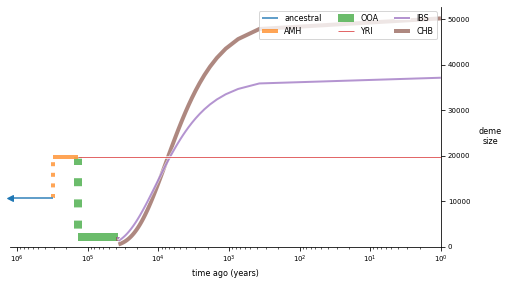

In [20]:
opt_model = demes.load(output)
demesdraw.size_history(opt_model, invert_x=True, log_time=True);

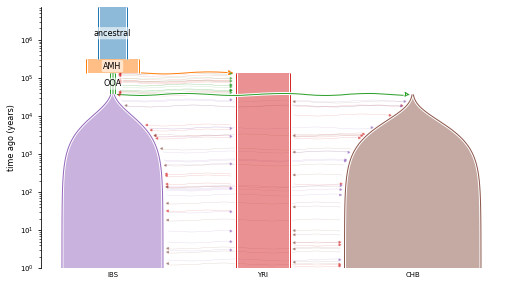

In [21]:
demesdraw.tubes(opt_model, log_time=True);

## Comparing SFS: model vs data

In [22]:
sf_expected = moments.Spectrum.from_demes(output, sf.pop_ids, sf.sample_sizes)

In [23]:
sf_expected.pop_ids

['CHB', 'IBS', 'YRI']

['YRI']


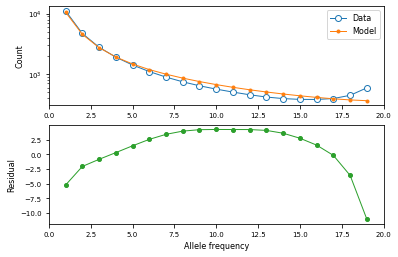

In [24]:
yr_mdl = sf_expected.marginalize([0, 1])
yr_data = sf.marginalize([0, 1])
print(yr_data.pop_ids)

moments.Plotting.plot_1d_comp_multinom(yr_mdl, yr_data)

['IBS']


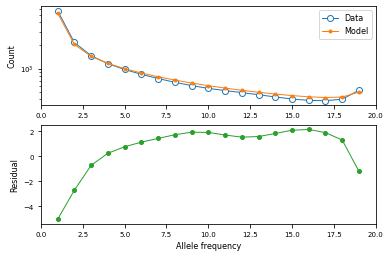

In [25]:
yr_mdl = sf_expected.marginalize([0, 2])
yr_data = sf.marginalize([0, 2])
print(yr_data.pop_ids)

moments.Plotting.plot_1d_comp_multinom(yr_mdl, yr_data)

['CHB']


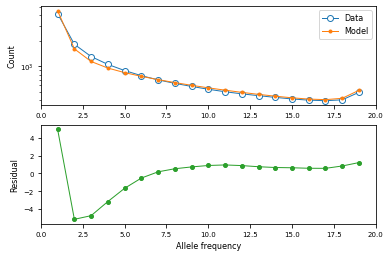

In [26]:
yr_mdl = sf_expected.marginalize([1, 2])
yr_data = sf.marginalize([1, 2])
print(yr_data.pop_ids)

moments.Plotting.plot_1d_comp_multinom(yr_mdl, yr_data)

['CHB', 'YRI']


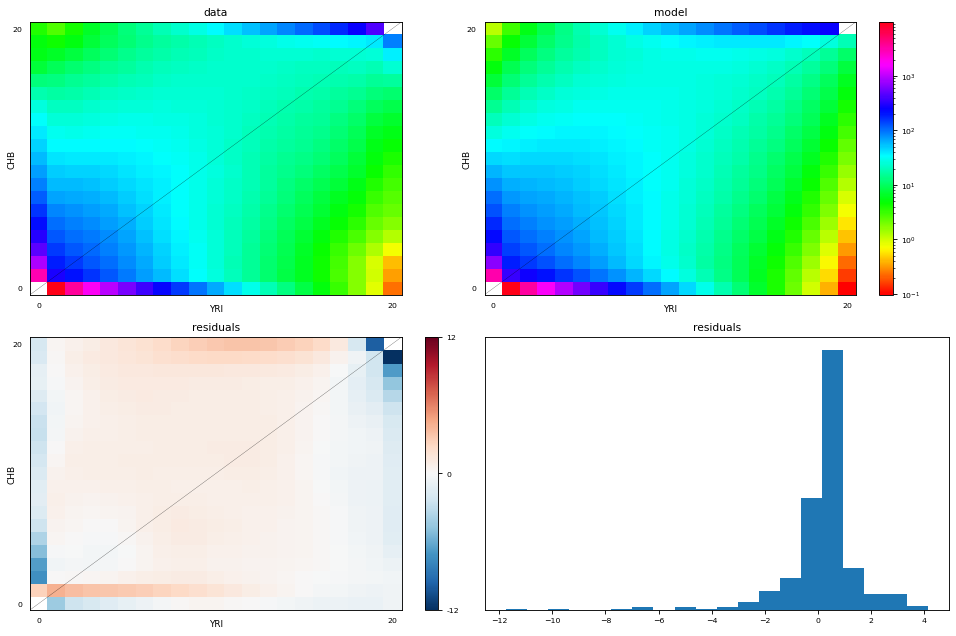

In [27]:

yr_mdl = sf_expected.marginalize([1])
yr_data = sf.marginalize([1])
print(yr_data.pop_ids)
plt.figure(figsize=(12, 8), dpi=80)
moments.Plotting.plot_2d_comp_multinom(yr_mdl, yr_data);

['CHB', 'IBS']


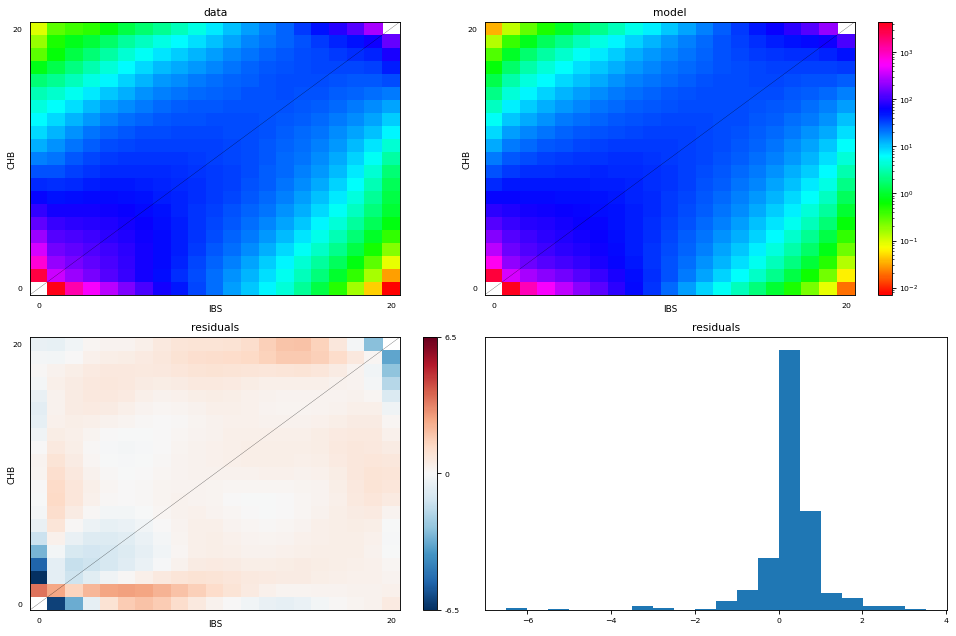

In [28]:
yr_mdl = sf_expected.marginalize([2])
yr_data = sf.marginalize([2])
print(yr_data.pop_ids)
plt.figure(figsize=(12, 8), dpi=80)
moments.Plotting.plot_2d_comp_multinom(yr_mdl, yr_data);